# CESSIPy: um módulo em Python de código aberto para Identificação Modal Estocástica de Estruturas

A identificação de sistemas visa mensurar a descrição matemática de um sistema analisando as suas entradas e saídas. No contexto da Engenharia Civil, as estruturas como edifícios, torres e pontes são os sistemas e os parâmetros a serem identificados são as frequências naturais, razões de amortecimentos e formas modais. As entradas são os carregamentos aplicados e as saídas são as respostas estruturais, as quais podem ser medidas em termos de deslocamentos, velocidades ou acelerações.

A identificação de estruturas a partir de excitações ambientais é denominada identificação estocástica de sistemas ou ainda identificação modal estocástica. Nestas apenas a resposta (saída) é medida, sendo a excitação considerada como um processo estocástico multidimensional, representado tipicamente por um ruído branco.

O principal objetivo do CESSIPy é a identificação das propriedades dinâmicas de estruturas quando apenas as saídas são medidas. Programaram-se:
1. Método Básico no Domínio da Frequência (BFD) também chamado de Método de Detecção de Picos (*Peak Picking Method* - PP)
2. Método Aperfeiçoado de Decomposição no Domínio da Frequência (*Enhanced Frequency Domain Decomposition* - EFDD)
3. Método de Identificação Estocástica de Subespaços baseados nas Covariâncias (*Covariance-driven Stochastic Subspace Identification* - SSI COV)
4. Método das Variáveis Instrumentais (*Instrumental Variable* - IV)
5. Método de Identificação Estocástica de Subespaços baseados nas Séries Temporais (*Data-driven Stochastic Subspace Identification* - SSI DATA)


Neste texto apresenta-se uma breve descrição dos métodos e o uso das rotinas programadas para a identificação de uma estrutura simples. 

---

**Endereços úteis:**
* Texto da tese (em breve)
* [Download da distribuição Python da Anaconda](https://www.anaconda.com/products/individual)
* Identificação de uma laje com o celular

---
**Como citar este trabalho:**
Em breve

---

## Índice

1. [Estrutura exemplo](#1)  


2. [Identificação de sistemas no domínio da frequência](#2)                           
   2.1.  [Densidades espectrais](#2.1)                                                  
   2.2.  [Método Básico no Domínio da Frequência (BFD)](#2.2)                      
   2.3.  [Método de Aperfeiçoado de Decomposição no Domínio da Frequência (EFDD)](#2.3)                                       


3. [Identificação de sistemas no domínio do tempo](#3)                             
   3.1.  [Séries temporais](#3.1)                                       
   3.2.  [Estimativas das funções de covariância](#3.2)                                           
   3.3.  [Métodos de Identificação Estocástica de Subespaços (SSI)](#3.3)                                                       
   3.3.1.  [Identificação baseada nas covariâncias (SSI COV)](#3.3.1)                                     
   3.3.2.  [Identificação baseada nas séries temporais (SSI DATA)](#3.3.2)                                                 
   3.3.3.  [Algoritmo mais eficiente para determinação das matrizes do sistema](#3.3.3)                                     
   3.4.  [Método das Variáveis Instrumentais (IV)](#3.4)                                      
 
 
4. [Outras rotinas](#4)                         
   4.1.  [Gráfico das propriedades dinâmicas de edifícios](#4.1)                     
   4.2.  [Critério de Concordância Modal (MAC)](#4.2)                                 
   4.3.  [Gráfico dos valores singulares](#4.3)                                             

In [63]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import CESSIPy           as SSI
from   MRPy import MRPy
%matplotlib inline

## 1. Estrutura exemplo <a name="1"></a>

Visando facilitar a compreensão das rotinas, os métodos são empregados na identificação de uma estrutura simples submetida a forças aleatórias. 

Trata-se de um pórtico plano com três pavimentos retirado de Clough e Penzien (2003, p. 203). As massas são concentradas nas lajes, enquanto a flexibilidade é atribuída exclusivamente à deformação por flexão dos pilares. Como consequência, a estrutura tem deformações horizontais em forma de corte (*shear building*), com contribuição da flexão global desprezível.

<img src="img/1 - Pórtico.jpg" width="380">

---

Inicialmente definem-se os parâmetros:

In [64]:
H = 3      # altura do pavimento [m]
ζ = 0.015  # razão de amortecimento crítico [-]

A matriz de massa $\mathbf{M}$ é (CLOUGH; PENZIEN, 2003, p. 203):

In [65]:
M = 1*175127*np.array(([ 1.0,   0,   0],
                       [   0, 1.5,   0],
                       [   0,   0, 2.0]))

Sendo utilizada a conversão 1 kip.sec² / in = 175127 kg.

A determinação da matriz de rigidez $\mathbf{K}$ da estrutura é apresentada em Clough e Penzien (2003, p. 203).
A montagem da matriz de rigidez é feita aplicando-se deslocamentos unitários em cada pavimento isoladamente.

<img src="img/2 - Matriz de Rigidez.jpg" width="650">

Resultando na matriz:

In [66]:
K = 600*175127*np.array(([  1, -1,  0], 
                         [ -1,  3, -2],
                         [  0, -2,  5]))

Sendo utilizada a conversão 1 kips / in = 175127 N/m.

---
Deseja-se estudar a determinação das frequências naturais (autovalores) e das formas modais (autovetores) de uma estrutura com $n$ graus de liberdade. Parte-se do caso mais simples, correspondente a um sistema não amortecido em vibração livre:

$$ \mathbf{M}\ddot{\vec u} (t) + \mathbf{K} \vec u(t)=0\tag{1}$$

Sendo $\vec u(t)$ e $\ddot{\vec u}(t)$ os vetores deslocamentos e  acelerações generalizados, respectivamente.

No método da superposição modal, escreve-se o vetor deslocamento como a soma dos deslocamentos modais:

$$\vec u (t) = \sum_{i=1}^n u_i(t) \vec \phi_i = \Phi \vec u_m (t) \tag{2}$$

Sendo $u_i(t)$ a resposta modal, $\vec \phi_i$ a forma modal, $\Phi$ a matriz cujas colunas são as formas modais e $\vec u_m (t)$ o vetor das respostas modais.

As formas modais $\vec \phi_i$ e as respectivas frequências naturais $\omega_i$ são determinadas a partir da solução do problema de autovalores e autovetores:

$$ \mathbf{K} \vec \phi_i = \omega_i^2 \mathbf{M} \vec \phi_i \tag{3}$$

O qual pode ser escrito na forma convencional:

$$ \mathbf{K}^{-1} \mathbf{M} \vec \phi_i = \frac{1}{\omega_i^2} \vec \phi_i \tag{4}$$

In [67]:
Λ, Q = np.linalg.eig(np.linalg.inv(K) @ M) 

Os autovetores são agrupados, um em cada coluna, formando a matriz $\mathbf{\Phi}$. Tornando a componente modal no topo unitária, é possível compará-los com os calculados por Clough e Penzien (2003, p. 207).

In [68]:
pd.DataFrame(Q/Q[0,:],columns=['Modo 1','Modo 2','Modo 3'])

,Modo 1,Modo 2,Modo 3
0,1.000000,1.000000,1.000000
1,0.648535,-0.606599,-2.541936
2,0.301850,-0.678977,2.439628


As frequências naturais são determinadas a partir dos autovalores ```Λ```:

In [69]:
ωn = (1/Λ)**.5            # frequências naturais circulares [rad/s]
fn = ωn/(2*np.pi)         # frequencias naturais [Hz]

for j, (k,l) in enumerate(zip(ωn,fn)):
    print('ω{0} = {1:3.3f} rad/s    f{0} = {2:2.4f} Hz'.format(j+1,k,l))

ω1 = 14.522 rad/s    f1 = 2.3112 Hz
ω2 = 31.048 rad/s    f2 = 4.9414 Hz
ω3 = 46.099 rad/s    f3 = 7.3370 Hz


As quais são iguais as calculadas por Clough e Penzien (2003, p. 204).

É conveniente ajustar a escala das formas modais de modo a obter massas modais unitárias:

$$\mathbf{\Phi}^T\mathbf{M}\mathbf{\Phi}=\mathbf{I}_n \tag{5}$$

Sendo $\mathbf{I}_n$ a matriz identidade de dimensões $n\times n$.

In [70]:
Mk = np.diag(Q.T @ M @ Q)  # massa modal
Q  = Q/Mk**0.5             # normaliza forma modal de modo que as massas modais sejam unitárias

Demonstrando que as massas modais são unitárias:

In [71]:
Mk = Q.T @ M @ Q
Mk

array([[ 1.00000000e+00,  5.52118756e-16, -3.28436546e-16],
       [ 5.36755073e-16,  1.00000000e+00,  1.79685031e-16],
       [-3.29470757e-16,  1.46502042e-16,  1.00000000e+00]])

Por fim, define-se o vetor com as alturas de cada pavimento `x` e plotam-se as propriedades dinâmicas da estrutura simulada.

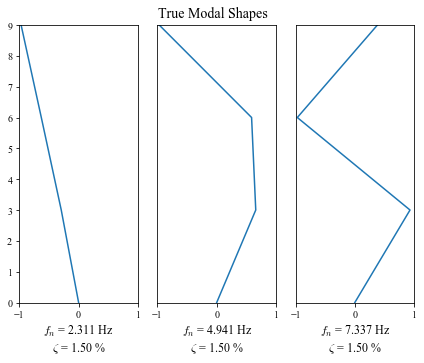

In [72]:
x  = np.linspace(3*H,H,3)
SSI.plot_1dshapes(fn,ζ*np.ones(3),Q,'True',x,fix=[0])

O parâmetro ```fix=[0]``` adiciona uma componente nula à forma modal na altura 0.

Uma descrição detalhada das funções programadas pode ser obtida escrevendo o nome da função acompanhado de `?`.

---
Visando determinar a resposta estrutural, definem-se o número de pontos no tempo $N$ e a frequência de amostragem $f_s$:

In [73]:
N  = 2**15                              # número de pontos no tempo
fs = 25                                 # frequência de amostragem [Hz]

As forças aplicadas em cada pavimento são consideradas aleatórias com distribuição gaussiana:

In [74]:
F  = MRPy(5E3*np.random.randn(3,N),fs=fs)   # forças nodais [N]

A resposta dinâmica de um sistema com $n$ graus de liberdade é determinada através da solução da equação matricial de equilíbrio dinâmico:

$$ \mathbf{M}\ddot{\vec u} (t) +\mathbf{C}_f\dot{\vec u} (t)+ \mathbf{K} \vec u(t)=\vec F (t) \tag{6}$$

Sendo $\mathbf{C}_f$ a matriz de amortecimento, $\dot{\vec u}(t)$ o vetor velocidades e $\vec F(t)$ o vetor das cargas.

No método da superposição modal, a equação matricial de equilíbrio dinâmico é desacoplada em equações diferenciais isoladas, uma para cada modo. Pré-multiplicando-se a equação anterior por $\mathbf{\Phi}^T$ e utilizando a definição $(2)$:

$$ \mathbf{\Phi}^T\mathbf{M}\mathbf{\Phi}\ddot{\vec u}_m (t) + \mathbf{\Phi}^T \mathbf{C}_f\mathbf{\Phi}\dot{\vec u}_m (t)+ \mathbf{\Phi}^T \mathbf{K}\mathbf{\Phi} \vec u_m(t)=\mathbf{\Phi}^T\vec F (t) \tag{7}$$

Sendo $ \mathbf{\Phi}^T\mathbf{M}\mathbf{\Phi}$ a matriz diagonal com as massas modais $m_i$, $\mathbf{\Phi}^T \mathbf{C}_f\mathbf{\Phi} $ a matriz dos amortecimentos modais, $\mathbf{\Phi}^T \mathbf{K}\mathbf{\Phi}$ a matriz diagonal com as rigidezes modais $k_i$ e $\mathbf{\Phi}^T\vec F (t) = \vec{F_m}(t)$ o vetor das forças modais.

As forças modais são calculadas:

In [75]:
Fk = MRPy(np.dot(Q.T,F),fs=fs)                     # forças modais

Admitindo-se amortecimento proporcional, assume-se que os autovetores diagonalizam a matriz $\mathbf{C}_f$:

$$\mathbf{\Phi}^T \mathbf{C}_f\mathbf{\Phi} = \mathrm{diag}(c_i) = \mathrm{diag}(2\zeta_i\omega_i m_i) \tag{8}$$

Sendo $c_i$ os amortecimentos modais e $\zeta_i$ a razão de amortecimento crítico.

Assim, a equação matricial $(6)$ resulta em equações diferenciais desacopladas, uma para cada modo:

$$m_i \ddot u_i (t)+ c_i \dot u_i (t) + k_i u_i (t) = F_i (t) \tag{9}$$

As quais são resolvidas separadamente no domínio da frequência.

In [76]:
Xk = MRPy.sdof_Fourier(Fk,fn,ζ)                     # respostas modais

Com a equação $(2)$, obtém-se os deslocamentos e, derivando-os duas vezes, as acelerações.

In [77]:
X  = MRPy(np.dot(Q,Xk),fs=fs)                      # deslocamentos
A  = MRPy.differentiate(MRPy.differentiate(X))     # acelerações

As séries temporais das acelerações são as únicas informações que os métodos de identificação empregam.
Um gráfico pode ser facilmente plotado.

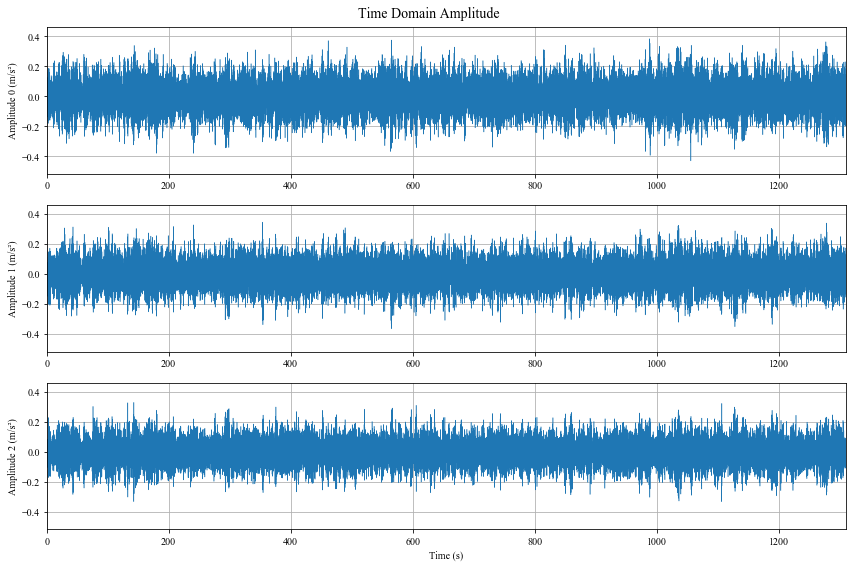

In [78]:
h1 = A.plot_time(unit=' (m/s²)')

---
## 2. Identificação de sistemas no domínio da frequência <a name="2"></a>

Os métodos de identificação podem ser divididos de acordo com o tipo de dados que empregam: séries temporais, covariâncias ou densidades espectrais. Inicia-se a apresentação pelos métodos no domínio da frequência para corresponder à ordem histórica da identificação estocástica de sistemas. Apesar das medições estarem no domínio do tempo, é muito útil analisar as suas representações no domínio da frequência. 

### 2.1. Densidades espectrais <a name="2.1"></a>

Os métodos BFD e EFDD assumem que a estrutura está sujeita a excitações aleatórias do tipo ruído branco e empregam a matriz das densidades espectrais da resposta $\mathbf{G}(f)$:

$$ \mathbf{G}(f) = E\left[\mathbf{Y}(f)\mathbf{Y}^{H}(f)\right] \tag{10}$$

Sendo $\mathbf{Y}$ a resposta da estrutura no domínio da frequência. O superescrito $(\cdot)^H$ denota complexo conjugado transposto e $E[\cdot]$ valor esperado.

As estimativas das funções de densidades espectrais são calculadas e plotadas pela função `SDM`, a qual emprega a função `scipy.signal.csd`. Os termos da diagonal são chamados de autoespectros e os demais de espectros cruzados. Os sinais são divididos em segmentos com `nperseg` pontos visando obter estimativas suavizadas e, por padrão, são multiplicados por uma janela de dados do tipo Hanning.

Uma forma de visualização da matriz espectral é apresentada abaixo.

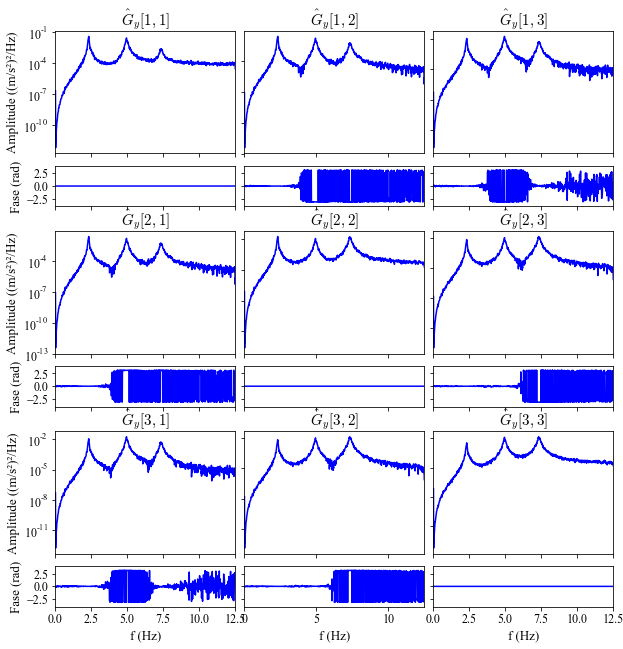

In [79]:
nps = A.N//16
PSD = SSI.SDM(A, nperseg=nps, plot=True) 

As densidades espectrais são salvas no objeto `PSD` como um array tridimensional. Nele, os dois primeiros índices correspondem aos sinais e o terceiro à frequência. Por exemplo, as densidades espectrais para a frequência nula são:

In [80]:
PSD[:,:,0]

auxclass([[4.18845335e-07+0.j, 1.70219132e-07+0.j, 1.03352524e-07+0.j],
          [1.70219132e-07+0.j, 1.46027128e-07+0.j, 3.10486764e-08+0.j],
          [1.03352524e-07+0.j, 3.10486764e-08+0.j, 1.33657338e-07+0.j]])

Note que `PSD` é um objeto com as frequências no atributo `PSD.f` e o número de pontos de cada segmento `PSD.nperseg`.

### 2.2. Método Básico no Domínio da Frequência (BFD) <a name="2.2"></a>

A abordagem mais simples para estimar as características dinâmicas da estrutura submetida a ações ambientais é o Método de Detecção de Picos (*Peak Picking method* – PP) também chamado de Método Básico no Domínio da Frequência (*Basic Frequency Domain method* - BFD). Conforme o próprio nome sugere, a identificação das frequências naturais é feita selecionando-se os picos das densidades espectrais das respostas. Para estruturas pouco amortecidas e com modos bem separados, tanto os autoespectros quanto os espectros cruzados atingem um valor máximo na frequência de ressonância. Na vizinhança de uma frequência de ressonância $f_r$, a matriz espectral pode ser aproximada como:

$$ \mathbf{G}(f_r) \approx \alpha_r\vec\phi_r\vec\phi^H_r \tag{11}$$

Sendo $\alpha_r$ uma constante que depende da frequência natural, do amortecimento e da participação modal e $\vec\phi_r$  uma estimativa da forma modal.

O espectro normalizado médio (ANPSD), proposto por Felber (1993), sintetiza em um único gráfico a informação contida em todos os autoespectros e nele inicia-se o processo de identificação detectando seus picos.

A função programada possui dois modos: `'interactive'` e `'batch'`. Inicia-se a apresentação pelo modo padrão `'interactive'`.

Ao chamar a função `ANPSD_from_SDM`, uma janela gráfica surgirá. Nela, a seleção dos picos deve ser feita clicando-se nos picos com o botão esquerdo do mouse. As linhas pretas indicam a frequência sendo selecionada (ignore a cruz vermelha na localização de cada clique). Uma vez que todos os picos estejam marcados, clica-se no botão central para finalizar. Caso seja necessário desconsiderar o ponto selecionado, deve-se pressionar o botão direito. É possível empregar a ferramenta nativa de zoom desde que após o seu uso seja desfeita a ação com o botão direito do mouse pois o Python entende que o clique do zoom é uma seleção de pico. A imagem abaixo apresenta um exemplo de uso.

<img src="img/3 - ANPSD.jpg" width="700">

Na célula abaixo, pressione Enter e selecione os picos no gráfico que aparecerá na tela.

In [81]:
input ('Pressione Enter para continuar')

%matplotlib qt
PSD = SSI.ANPSD_from_SDM(PSD)

Pressione Enter para continuar


O objeto `PSD` recebe o atributo `PSD.ANPSD` e `PSD.pki` contendo o espectro normalizado médio e os índices dos picos selecionados pelo usuário, respectivamente.

No método BFD, as frequências naturais estimadas correspondem aos picos da densidades espectrais:

In [82]:
for k, j in enumerate(PSD.pki):
    print('fn{0} = {1:7.4f} Hz'.format(k+1,PSD.f[j]))

fn1 =  2.3193 Hz
fn2 =  4.9438 Hz
fn3 =  7.3120 Hz


Conforme mencionado, o modo padrão de `ANPSD_from_SDM` é `'interactive'`, no qual os picos são selecionados com o mouse.
O usuário pode alterar as frequências especificadas modificando diretamente o atributo `PSD.pki`.

O outro modo é chamado de `'batch'` e permite a execução do código de forma automatizada, sem a interação do usuário. Nele, o atributo `PSD.pki` deve conter os índices das frequências dos picos.

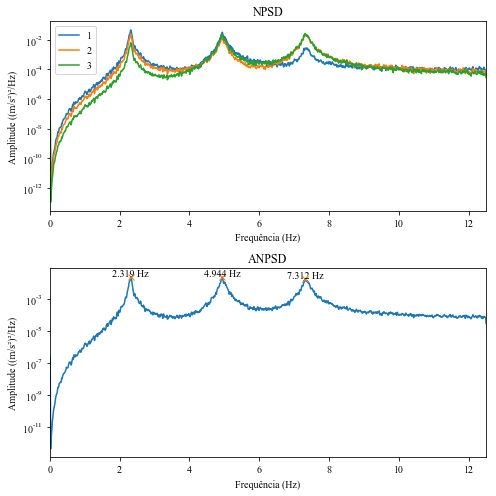

In [83]:
%matplotlib inline
PSD = SSI.ANPSD_from_SDM(PSD,mode='batch',plot=True)

A identificação das formas modais e razões de amortecimento é feita pela função `BFD`. 
O amortecimento é estimado por dois métodos: o método de meia-potência e ajuste ao espectro analítico. 

No método da meia potência, a razão de amortecimento é estimada a partir das frequências do pico $f_r$ e das frequências com ordenada espectral igual a metade da ordenada máxima $f_a$ e $f_b$ (EWINS, 2000):

$$\zeta_i = \frac{f_b^2-f_a^2}{4f_r^2} \tag{12}$$

No método de ajuste ao espectro analítico, seleciona-se um trecho das densidades espectrais na vizinhança do pico e ajusta-se a curva corresponde ao espectro da resposta em aceleração de um sistema de um grau de liberdade sujeito a uma entrada de densidade espectral constante:

$$G_y(f) = C_1 \left| \frac{f^2}{1-\left(f / f_n\right)^2+j2\zeta\left(f / f_n\right)}\right|^2 + C_2 \tag {13}$$

Sendo $C_1$ uma constante que depende da rigidez do sistema e da densidade espectral da entrada, $f_n$ a frequência natural não amortecida, $\zeta$ o razão de amortecimento, $j$ a unidade imaginária e $C_2$ uma constante que leva em conta a influência dos modos fora da zona do pico analisado.

Uma vez chamada a função, por padrão ela emprega o modo `'interactive'`. Primeiramente deve-se clicar no autoespectro a ser utilizado para estimativa do amortecimento (normalmente escolhe-se aquele em que a densidade espectral possui maior amplitude), conforme figura abaixo.

<img src="img/4 - Autoespectros.jpg" width="700">

Em seguida, deve-se selecionar o extremo inferior e o superior do intervalo a ser empregado para ajuste ao espectro analítico, por exemplo:

<img src="img/5 - Autoespectros.jpg" width="600">

O código abaixo apresenta a chamada da função. Pressione Enter para realizar a seleção gráfica.

In [84]:
input('Pressione Enter para continuar')

%matplotlib qt
FBFD, ZBFD, VBFD, PSD = SSI.BFD(A, PSD, plot=False)

Pressione Enter para continuar
Selecione o autoespectro de referência


As razões de amortecimento estimadas pelo método da meia-potência são `ZBFD[0]` e pelo ajuste ao espectro analítico `ZBFD[1]`.

In [85]:
print('Meia Potência  Espectro Analítico')
for j, (k,l) in enumerate(zip(ZBFD[0],ZBFD[1])):
    print('ζ{0} = {1:4.2f}%     ζ{0} = {2:4.2f}%'.format(j+1,k*100,l*100))

Meia Potência  Espectro Analítico
ζ1 = 1.43%     ζ1 = 1.45%
ζ2 = 0.78%     ζ2 = 1.48%
ζ3 = 1.16%     ζ3 = 1.32%


E as propriedades dinâmicas identificadas:

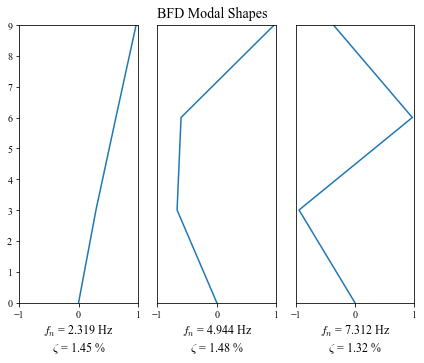

In [86]:
%matplotlib inline
SSI.plot_1dshapes(FBFD,ZBFD[1],VBFD,'BFD',x,fix=[0])

Após o uso da função `BFD` no modo `'interactive'`, o objeto `PSD` recebe vários atributos:

In [87]:
PSD.pki # índice dos picos das densidades espectrais

array([190, 405, 599], dtype=int64)

In [88]:
PSD.MGi # índice dos autoespectros empregados para determinação do amortecimento

array([0, 0, 1])

In [89]:
PSD.fint # frequências inferior e superior empregadas para ajuste ao espectro analítico

array([1.58691406, 3.18603516, 4.37011719, 5.89599609, 6.86035156,
       8.47167969])

Esses atributos podem ser alterados para a realização de ajustes aos dados informados com o mouse. Também podem ser definidos antes da chamada da função, permitindo o uso do modo `'batch'`. 
A entrada `plot=True` permite verificar graficamente as frequências de meia-potência e o espectro analítico ajustado.

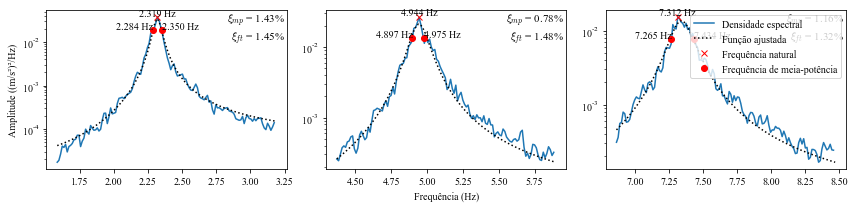

In [90]:
FBFD, ZBFD, VBFD, PSD = SSI.BFD(A, PSD, plot=True, mode='batch')

As funções de coerência permitem confirmar se as estimativas das formas modais são confiáveis. Na frequência de ressonância, a função de coerência deve ser próxima a 1. 

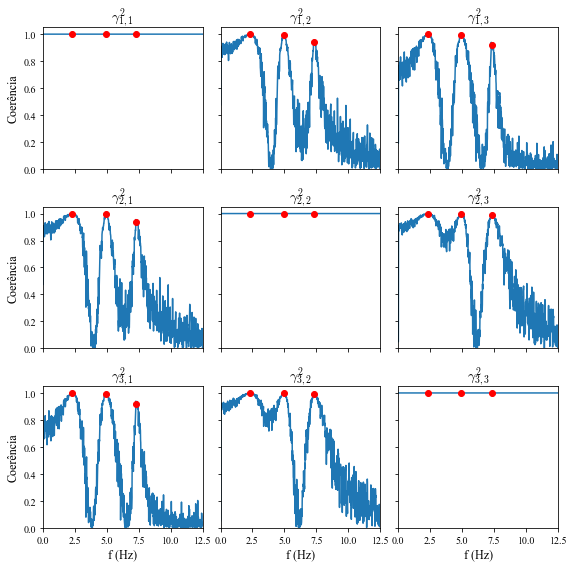

In [91]:
γ   = SSI.coherence(A, PSD, nps, plot=True)

### 2.3. Método Aperfeiçoado de Decomposição no Domínio da Frequência (EFDD) <a name="2.3"></a>

O método EFDD, formalizado por Brincker et al. (2000, 2001), aplica a decomposição em valores singulares (SVD) à matriz espectral para cada frequência, visando decompor o sistema estrutural em uma série de sistemas com um grau de liberdade. A SVD da matriz espectral é:

$$\mathbf{G}(f)=\mathbf{U}(f)\mathbf{\Sigma}(f)\mathbf{U}^{H}(f) \tag{14}$$

Sendo $\mathbf{\Sigma}$ uma matriz diagonal com os valores singulares em ordem decrescente e $\mathbf{U}$ uma matriz complexa com os vetores singulares. Os valores singulares não nulos representam fisicamente o espaço do sinal enquanto os valores próximos a zero indicam o espaço do ruído. Se apenas um modo é importante numa certa frequência $f_r$, a matriz espectral pode ser aproximada por uma matriz com posto um com o valor singular máximo:

$$\mathbf{G}(f)\cong \sigma_1(f_r)\vec u_1(f_r)\vec u_1^H(f_r) \tag{15}$$

O vetor singular $\vec u_1(f_r)$ é uma estimativa para a forma modal $\vec\phi_r$. No caso de modos pouco espaçados, mais de um valor singular atingirá um máximo nas vizinhanças de uma certa frequência, e todos os vetores singulares correspondentes a valores singulares não nulos são estimativas das formas modais (HU et al., 2009).

Na avaliação das densidades espectrais, Bendat e Piersol (2010) não recomendam empregar janela de dados, o que pode ser feito especificando `window='boxcar'`. Os autores também recomendam aumentar cada segmento de `nps` valores com `nps` zeros, o que pode ser feito especificando `nfft=2*nps`.

In [92]:
P2SD = SSI.SDM(A, nperseg=nps, plot=False,window='boxcar',nfft=2*nps) 

Programou-se o método na rotina `EFDD`, a qual roda por padrão no modo `'interactive'`.

Uma vez chamada, clicam-se nos picos das densidades espectrais dos valores singulares:
<img src="img/6 - Valores Singulares.jpg" width="600">

Em seguida, seleciona-se o trecho da densidade espectral no domínio da frequência. Fora desse trecho, o espectro terá valores nulos. 

Visando auxiliar na sua definição, calcula-se o Critério de Concordância Modal (MAC) entre o vetor singular do topo e os demais. Ele é uma medida de correlação entre duas formas modais. O seu valor varia entre 0 e 1, sendo igual zero para modos não correlacionados e um para modos perfeitamente correlacionados (para mais detalhes, ver item [4.2](#4.2)). O trecho no qual MAC > 0.8 é indicado na cor laranja

<img src="img/7 - Frequências.jpg" width="600">

Transformando para o domínio do tempo a função de densidade espectral de cada modo de vibração, obtém-se a função de autocorrelação. A partir desta, determinam-se a frequência natural e a razão de amortecimento ajustando-se a expressão da resposta em vibração livre amortecida:

$$y(t) = y_p \exp^{-\eta t}\cos \left ( \omega_d t \right) \tag{16}$$

Sendo $y_p$ a amplitude, $\eta = \omega_n \zeta$ e $\omega_d$ a frequência natural amortecida $\omega_d = \omega_n \sqrt{1-\zeta^2}$.

No gráfico, seleciona-se o trecho da função de autocorrelação a ser empregado para ajuste da função teórica. Os valores são plotados em módulo visando facilitar a definição do trecho.

<img src="img/8 - Autocorrelação.jpg" width="400">

O ajuste é feito em dois passos. No primeiro, ajusta-se o envelope $y(t) = y_p \exp^{-\eta t}$ obtendo-se $\eta$ e $y_p$. No segundo passo, ajusta-se a resposta em vibração livre amortecida obtendo-se $f_n$ e $\zeta$.

In [93]:
input('Pressione Enter para continuar')

%matplotlib qt
FFDD, ZTFDD, VFDD, P2SD = SSI.EFDD(A,P2SD,plot=False)

Pressione Enter para continuar
Selecione os picos no gráfico


As propriedades dinâmicas identificadas são apresentadas abaixo.

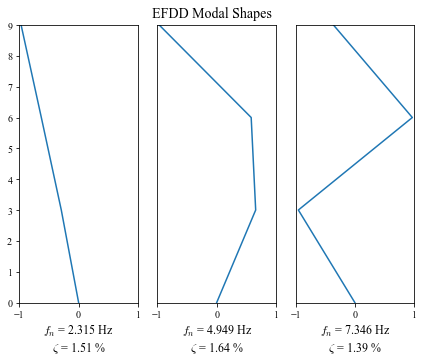

In [94]:
%matplotlib inline
SSI.plot_1dshapes(FFDD,ZTFDD,VFDD,'EFDD',x,fix=[0])

Após o uso da função `EFDD` no modo `'interactive'`, o objeto `P2SD` recebe vários atributos:

In [95]:
P2SD.pki  # índice dos picos das densidades espectrais

array([ 381,  812, 1198], dtype=int64)

In [96]:
P2SD.svi  # índice dos valores singulares dos picos

array([0, 0, 0], dtype=int64)

In [97]:
P2SD.fint # frequências inferior e superior empregadas para ajuste ao espectro analítico

array([1.51367188, 3.3203125 , 4.25415039, 5.87768555, 6.81152344,
       8.25805664])

In [98]:
P2SD.tint # tempo inferior e superior empregados para ajuste da função de autocorrelação

array([0.16, 8.96, 0.32, 3.36, 0.32, 2.88])

Esses atributos podem ser definidos antes da chamada da função. Eles só são empregados no modo `'batch'`.

Os gráficos das funções de autocorrelação apresentam os pontos obtidos a partir da transformada inversa de Fourier das densidades espectrais e as curvas ajustadas para a obtenção das frequências naturais e razões de amortecimento.

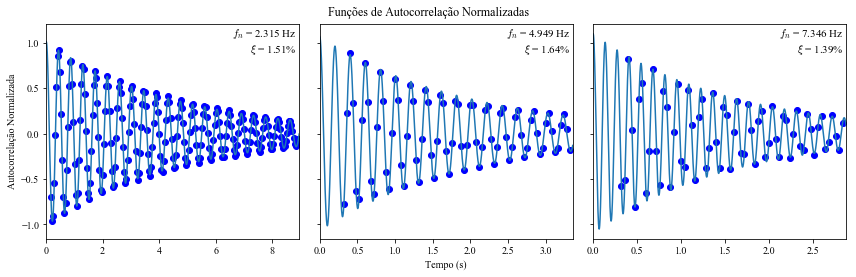

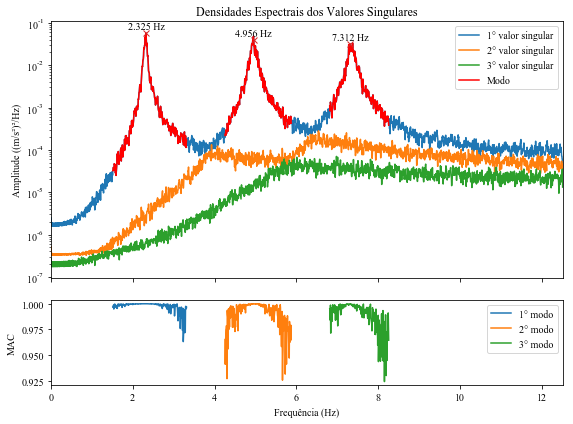

In [99]:
%matplotlib inline
FFDD, ZTFDD, VFDD, P2SD = SSI.EFDD(A,P2SD,plot=True, mode='batch')      

## 3. Identificação de sistemas no domínio do tempo <a name="3"></a>

Os métodos descritos a seguir são o Método das Variáveis Instrumentais (IV), o Método de Identificação Estocástica de Subespaços baseada nas Covariâncias (SSI COV) e baseada nas séries Temporais (SSI DATA), os quais empregam as funções de covariâncias ou diretamente as séries temporais. A formulação dos métodos não segue exatamente a forma original com que foram propostos, sendo adotada uma formulação unificada bastante próxima da apresentada por Peeters (2000).

### 3.1. Séries temporais <a name="3.1"></a>

As $l$ saídas medidas são divididas em um conjunto de $r$ sinais ou sensores de referência escolhidos adequadamente. O outro conjunto de resposta é composto de $(l-r)$ sensores. Rearranjando os dados de modo a posicionar as saídas de referência nas primeiras linhas:


$$ \vec y_{k} = \begin{bmatrix} \vec y_{k}^{ref} \\ \vec y_{k}^{\backsim} \end{bmatrix} \tag{17}$$

Sendo $\vec y_{k}^{ref}$ as saídas de referência e $\vec y_{k}^{\backsim}$ as demais saídas.

A função que rearranja os dados chama-se `rearrange_data` e recebe as séries temporais e a especificação dos sensores de referência:

In [100]:
ref = (0,1,2)   # todos os três sensores são de referrência                

yk = SSI.rearrange_data(A,ref)

Algumas saídas são classificadas como saídas de referência: aquelas que contém informação modal relevante ou capturam uma resposta estrutural específica. A escolha dos sensores de referência corresponde a escolha das localizações das excitações em uma análise modal tradicional. O emprego de sensores de referência foi introduzido por Peeters (2000) e permite reduzir as matrizes do sistema, levando a algoritmos mais rápidos e com menor custo computacional. Caso o tempo de processamento seja de pouca importância, pode-se empregar todos os sensores como sensores de referência. Se, por outro lado, apenas o primeiro sensor for de referência, especifica-se `ref=(0)`.

Agrupam-se as saídas em uma matriz bloco Hankel $\mathbf{H}^{ref} \in \mathrm{\mathbb{R}}^{(r+l)i\times N}$ (matriz cujos elementos da antidiagonal são iguais) composta por $2i$ linhas blocos e $N$ colunas. As primeiras $i$ linhas blocos possuem $r$ linhas cada e as últimas $i$ linhas bloco possuem $l$ linhas. Essa matriz pode ser dividida em uma parte de saídas chamadas passadas (subscrito $p$) e uma parte de saídas futuras (subscrito $f$), conforme equação $(18)$:

$$\mathbf{H}^{ref} = \frac{1}{\sqrt{N}} \begin{bmatrix} 
                     \vec y_{0}^{ref}   & \vec y_{1}^{ref} & \cdots & \vec y_{N-1}^{ref}   \\ 
                     \vec y_{1}^{ref}   & \vec y_{2}^{ref} & \cdots & \vec y_{N}^{ref}     \\
                     \vdots             & \vdots           & \ddots & \vdots               \\ 
                     \vec y_{i-1}^{ref} & \vec y_{i}^{ref} & \cdots & \vec y_{i+N-2}^{ref} \\ \hline
                     \vec y_{i}         & \vec y_{i+1}     & \cdots & \vec y_{i+N-1}       \\
                     \vec y_{i+1}       & \vec y_{i+2}     & \cdots & \vec y_{i+N}         \\
                     \vdots             & \vdots           & \ddots & \vdots               \\
                     \vec y_{2i-1}      & \vec y_{2i}      & \cdots & \vec y_{2i+N-1}  \end{bmatrix} 
                     = 
                     \begin{bmatrix} \mathbf{Y}_{p}^{ref} \\ \hline \mathbf{Y}_{f}\end{bmatrix}
                     \begin{matrix} \updownarrow ri \\ \updownarrow li\end{matrix}
                     \frac{\mathrm{"passado"}}{\mathrm{"futuro"}} \tag{18}$$
                 

### 3.2. Estimativas das funções de covariâncias <a name="3.2"></a>
 
As estimativas das funções de covariâncias são agrupadas em uma matriz Toeplitz $\mathbf{T}_{1|i}^{ref} \in \mathrm{\mathbb{R}}^{li\times ri}$ calculada com os dados da matriz Hankel:

$$\mathbf{T}_{1|i}^{ref} = \mathbf{Y}_{f} (\mathbf{Y}_{p}^{ref})^{T} = \begin{bmatrix} 
  \mathbf{R}_{i}^{ref}    & \mathbf{R}_{i-1}^{ref}  & \cdots & \mathbf{R}_{2}^{ref}   & \mathbf{R}_{1}^{ref} \\ 
  \mathbf{R}_{i+1}^{ref}  & \mathbf{R}_{i}^{ref}    & \cdots & \mathbf{R}_{3}^{ref}   & \mathbf{R}_{2}^{ref} \\
  \vdots                  & \vdots                  & \ddots & \vdots                 & \vdots               \\ 
  \mathbf{R}_{2i-1}^{ref} & \mathbf{R}_{2i-2}^{ref} & \cdots & \mathbf{R}_{i+1}^{ref} & \mathbf{R}_{i}^{ref} \end{bmatrix} \tag{19}$$


O parâmetro $i$ é escolhido pelo usuário e está associado à duração das funções de covariâncias, note que elas são estimadas até $2i-1$ atrasos no tempo. Uma escolha usual encontrada na literatura técnica é tomar $i=40$:

In [101]:
i = 40

### 3.3. Métodos de Identificação Estocástica de Subespaços (SSI) <a name="3.3"></a>

Os métodos de identificação estocástica de subespaços são formulados no espaço de estado em tempo discreto, no qual as matrizes do sistema são modeladas apenas em função das saídas: 

$$ \vec x_{k+1} = \mathbf{A} \vec x_{k} + \vec w_{k} \tag{20}$$

$$ \vec y_{k}   = \mathbf{C} \vec x_{k} + \vec z_{k} \tag{21}$$

Sendo $\vec x_{k}= [\vec u_k \ddot{\vec u_k} ]^T$ o vetor de estado no instante $k$ ($k=0,1,...,N-1$ com $N$ o número de amostras no tempo), $\vec w_{k}$ o vetor de perturbações e imprecisões no modelo, $\vec y_{k}$ o vetor de saídas, $ \vec z_{k}$ o vetor de ruídos nas medições, $\mathbf{A}$ a matriz dinâmica do sistema e $\mathbf{C}$ a matriz de influências nas saídas.

Estimando as matrizes $\mathbf{A}$ e $\mathbf{C}$ com algoritmos empregando as covariâncias (SSI COV) ou as séries temporais (SSI DATA), as propriedades dinâmicas da estrutura são identificadas (VAN OVERSCHEE; DE MOOR, 1996; PEETERS, 2000). As frequências naturais $f_{i}$, as razões de amortecimento $\zeta_{i}$ e as formas modais $\vec\phi_{i}$ são obtidas:


$$\mathbf{A} = \mathbf{\Psi\Lambda}_{d}\mathbf{\Psi}^{-1}, 
\mathbf{\Lambda}_{d}=\mathrm{diag}(\mu_i)\in\mathrm{\mathbb{C}}^{n_2×n_2} \tag{22a}$$

$$ \lambda_i=\frac{\ln\mu_i}{\Delta t} \tag{22b}$$

$$ f_i = \frac{|\lambda_i|}{2\pi} \tag{22c}$$

$$ \zeta_i = -\frac{\mathrm{real}(\lambda_i)}{|\lambda_i|} \tag{22d}$$

$$ \mathbf{V} = \mathbf{C} \mathbf{\Psi}, \mathbf{V}= [\vec\phi_{1}...\vec\phi_{n}] \tag{22e}$$

Sendo $ \mathbf{\Psi}$ e $\mathbf{\Lambda}_{d}$ os autovetores e os autovalores de $\mathbf{A}$, $\mu_i$ e $\lambda_i$ os autovalores em tempo discreto e contínuo, respectivamente. $\Delta t$ o período de amostragem e $|\cdot|$ denota o módulo complexo.

O número de linhas do vetor de estado $n_2$ é chamado de ordem do modelo ou número de estados. O processo de identificação é realizado para modelos com ordens crescentes e a identificação dos modos de vibração verdadeiros é feita com auxílio do diagrama de estabilização. Para estruturas reais, não é possível prever a ordem que melhor se ajusta aos dados experimentais e que fornece propriedades dinâmicas mais realísticas. Assim, a forma mais apropriada é superestimá-la. O uso de modelos de alta ordem leva à introdução de modos numéricos, os quais não têm importância física. Uma prática comum para separar os modos físicos dos espúrios é a criação de diagramas de estabilização. Nestes diagramas, os parâmetros modais estimados para todos os modelos são representados juntos, permitindo a identificação de modos estáveis para modelos de ordem crescente. Modos que aparecem com frequências, razões de amortecimento e formas modais semelhantes são classificados como estáveis e provavelmente são modos físicos. 

Essa classificação depende da definição de limites de variação para as propriedades. As tolerâncias são especificadas em um array bidimensional `tol`. A primeira linha se refere às frequências, a segunda às razões de amortecimento e a terceira ao MAC entre as formas modais. Na primeira coluna encontram-se as variações relativas limites para um modo ser classificado como estável, na segunda coluna o limite inferior e na terceira o superior. Por exemplo, `[0.01, 0, 15]` indica que a tolerância para frequências é de 1%, a frequência natural mínima é de 0 Hz e a máxima é de 15 Hz. Valores fora desse intervalo são associados com modos espúrios.

In [102]:
# tolerâncias: variação, limite inferior e limite superior
tol = np.array(([0.01,0, 15],       # frequência
                [0.05,0,.03],       # amortecimento
                [0.10,0,1  ]))      # MAC

### 3.3.1. Identificação baseada nas funções de covariâncias (SSI COV) <a name="3.3.1"></a>

O método de Identificação Estocástica de Subespaços baseados nas Covariâncias aborda o problema de realização estocástica, ou seja, o problema de identificar um modelo estocástico em espaço de estado com apenas saídas medidas. Este método baseia-se na decomposição em valores singulares da matriz de covariâncias das saídas $(19)$. Uma descrição detalhada é apresentada por Peeters (2000).

A função `SSI_COV` identifica o sistema de uma certa ordem em espaço de estado informada e a função `SSI_COV_iterator` itera a função `SSI_COV` para modelos de ordens crescentes.  A matriz Toeplitz e a sua decomposição em valores singulares são calculadas uma única vez, devendo-se respeitar a inequação $ri≥n_{2,max}$ sendo $n_{2,max}$ a ordem máxima do modelo em espaço de estado. Modelos de ordens inferiores $n_2<n_{2,max}$ são facilmente obtidos simplesmente selecionando-se menos valores singulares.

Considerando um modelo de ordem mínima igual a 2, máxima igual a 24 e com incrementos padrão de 2 em 2:

In [103]:
FNC, ZTC, VVC = SSI.SSI_COV_iterator(yk,i,2,24)

`FNC` e `ZTC` são arrays bidimensionais com as frequências e razões de amortecimento identificados. Cada linha se refere a um modelo. As propriedades do modelo de ordem $n_2=2$ encontram-se na primeira linha e de ordem $n_2=24$, na última. Por exemplo, as frequências e razões de amortecimento para o modelo de ordem $n_2=16$ são:

In [104]:
df = pd.DataFrame(np.array((FNC[7,:],ZTC[7,:])))
df.style.format('{:.3f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2.312,2.312,2.569,2.569,4.944,4.944,4.751,4.751,5.810,5.810,7.983,7.983,7.331,7.331,7.229,7.229,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.015,0.015,0.002,0.002,0.016,0.016,-0.011,-0.011,-0.006,-0.006,0.004,0.004,0.014,0.014,0.008,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


E as respectivas formas modais:

In [105]:
df = pd.DataFrame(VVC[7,:,:]*100)
df.style.format('{:.3f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,-4.073-1.202j,-4.073+1.202j,-0.296-0.168j,-0.296+0.168j,-3.930-2.907j,-3.930+2.907j,0.218-0.204j,0.218+0.204j,0.114-0.005j,0.114+0.005j,0.123-0.205j,0.123+0.205j,-1.438+0.922j,-1.438-0.922j,-0.310+0.356j,-0.310-0.356j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j
1,-2.637-0.782j,-2.637+0.782j,-0.203-0.122j,-0.203+0.122j,2.398+1.763j,2.398-1.763j,-0.073+0.159j,-0.073-0.159j,0.042-0.038j,0.042+0.038j,-0.100+0.282j,-0.100-0.282j,3.633-2.332j,3.633+2.332j,0.744-0.934j,0.744+0.934j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j
2,-1.228-0.363j,-1.228+0.363j,-0.098-0.077j,-0.098+0.077j,2.676+2.000j,2.676-2.000j,-0.125+0.118j,-0.125-0.118j,-0.125-0.133j,-0.125+0.133j,0.121-0.112j,0.121+0.112j,-3.509+2.250j,-3.509-2.250j,-0.734+0.968j,-0.734-0.968j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j


Nota-se que as propriedades dinâmicas aparecem aos pares. Isso acontece por causa da definição do vetor de estado. Como consequência, o mesmo modo é representado por dois estados.

Desenha-se um diagrama de estabilização e os modos físicos são identificados a partir dos polos estáveis. Um novo modo detectado é representado por um ponto na cor preta. Caso apenas a sua frequência estabilize (respeitando os limites de `tol[0]`), representa-se o ponto com a cor verde. Se além da frequência, a razão de amortecimento respeitar `tol[1]`, o ponto recebe a cor azul. Por fim, caso a frequência, razão de amortecimento e forma modal sejam estáveis, ou seja, se elas respeitam todos os limites especificados em `tol`, desenha-se o ponto na cor vermelha.

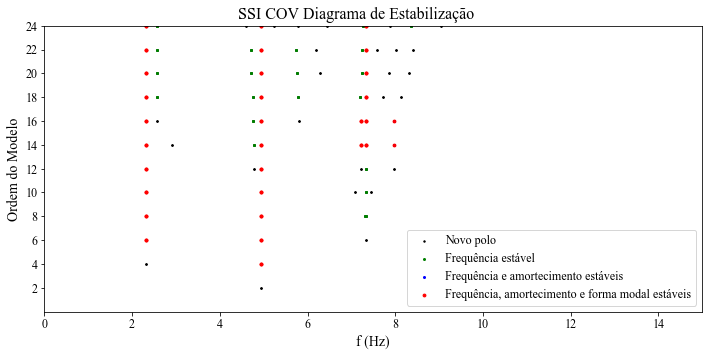

In [106]:
stbC = SSI.stabilization_diagram(FNC,ZTC,VVC,'SSI COV', tol=tol)

Os modos físicos são aqueles que apresentam propriedades dinâmicas estáveis para modelos de diferentes ordens. Os pontos vermelhos, formando uma reta vertical, provavelmente estão associadas a modos físicos.

`stbC` é um array booleano indicando os modos estáveis. É possível selecionar as frequências naturais e as razões de amortecimento desses modos:

In [107]:
df = pd.DataFrame(np.array((FNC[stbC],ZTC[stbC])))
df.style.format('{:.4f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,4.9443,4.9443,4.9441,4.9441,2.3112,2.3112,2.3112,2.3112,4.9441,4.9441,2.3112,2.3112,4.9441,4.9441,2.3112,2.3112,4.9436,4.9436,2.3110,2.3110,4.9435,4.9435,7.9811,7.2303,7.2303,7.3314,7.3314,2.3124,2.3124,4.9438,4.9438,7.9825,7.3314,7.3314,7.2289,7.2289,2.3124,2.3124,4.9438,4.9438,7.3426,7.3426,2.3124,2.3124,4.9437,4.9437,7.3395,7.3395,2.3124,2.3124,4.9435,4.9435,7.3425,7.3425,2.3125,2.3125,4.9438,4.9438,7.3396,7.3396
1,0.0157,0.0157,0.0158,0.0158,0.0149,0.0149,0.0149,0.0149,0.0158,0.0158,0.0149,0.0149,0.0158,0.0158,0.0149,0.0149,0.0162,0.0162,0.0148,0.0148,0.0162,0.0162,0.0040,0.0078,0.0078,0.0139,0.0139,0.0146,0.0146,0.0162,0.0162,0.0040,0.0139,0.0139,0.0079,0.0079,0.0146,0.0146,0.0161,0.0161,0.0138,0.0138,0.0146,0.0146,0.0161,0.0161,0.0144,0.0144,0.0146,0.0146,0.0161,0.0161,0.0139,0.0139,0.0146,0.0146,0.0157,0.0157,0.0145,0.0145


E as respectivas formas modais:

In [108]:
VE = [[],[],[]]
for j in range(stbC.shape[0]):
    VE = np.hstack((VE,VVC[j,:,stbC[j]].T))
df = pd.DataFrame(VE*100)
df.style.format('{:.3f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,-3.891-2.885j,-3.891+2.885j,3.927+2.890j,3.927-2.890j,-4.099-1.227j,-4.099+1.227j,4.099+1.227j,4.099-1.227j,-3.928-2.890j,-3.928+2.890j,-4.099-1.227j,-4.099+1.227j,3.928+2.890j,3.928-2.890j,4.099+1.226j,4.099-1.226j,3.927+2.909j,3.927-2.909j,4.093+1.230j,4.093-1.230j,-3.927-2.911j,-3.927+2.911j,0.124-0.207j,-0.305+0.364j,-0.305-0.364j,-1.438+0.922j,-1.438-0.922j,-4.073-1.202j,-4.073+1.202j,-3.930-2.907j,-3.930+2.907j,0.123-0.205j,-1.438+0.922j,-1.438-0.922j,-0.310+0.356j,-0.310-0.356j,-4.073-1.202j,-4.073+1.202j,-3.931-2.905j,-3.931+2.905j,1.438-1.023j,1.438+1.023j,-4.074-1.201j,-4.074+1.201j,-3.930-2.906j,-3.930+2.906j,1.456-0.996j,1.456+0.996j,4.074+1.201j,4.074-1.201j,-3.927-2.908j,-3.927+2.908j,1.433-1.016j,1.433+1.016j,-4.074-1.200j,-4.074+1.200j,-3.903-2.883j,-3.903+2.883j,1.450-0.989j,1.450+0.989j
1,2.312+1.744j,2.312-1.744j,-2.400-1.760j,-2.400+1.760j,-2.654-0.798j,-2.654+0.798j,2.654+0.798j,2.654-0.798j,2.401+1.758j,2.401-1.758j,-2.654-0.798j,-2.654+0.798j,-2.402-1.760j,-2.402+1.760j,2.654+0.798j,2.654-0.798j,-2.396-1.763j,-2.396+1.763j,2.649+0.800j,2.649-0.800j,2.396+1.761j,2.396-1.761j,-0.103+0.279j,0.734-0.947j,0.734+0.947j,3.633-2.330j,3.633+2.330j,-2.637-0.782j,-2.637+0.782j,2.398+1.763j,2.398-1.763j,-0.100+0.282j,3.633-2.332j,3.633+2.332j,0.744-0.934j,0.744+0.934j,-2.639-0.781j,-2.639+0.781j,2.399+1.762j,2.399-1.762j,-3.649+2.546j,-3.649-2.546j,-2.638-0.782j,-2.638+0.782j,2.400+1.764j,2.400-1.764j,-3.663+2.497j,-3.663-2.497j,2.638+0.782j,2.638-0.782j,2.398+1.766j,2.398-1.766j,-3.647+2.543j,-3.647-2.543j,-2.636-0.781j,-2.636+0.781j,2.382+1.759j,2.382-1.759j,-3.654+2.489j,-3.654-2.489j
2,2.763+2.002j,2.763-2.002j,-2.680-1.986j,-2.680+1.986j,-1.234-0.371j,-1.234+0.371j,1.234+0.371j,1.234-0.371j,2.678+1.987j,2.678-1.987j,-1.234-0.371j,-1.234+0.371j,-2.678-1.986j,-2.678+1.986j,1.234+0.372j,1.234-0.372j,-2.672-2.002j,-2.672+2.002j,1.232+0.374j,1.232-0.374j,2.671+2.001j,2.671-2.001j,0.121-0.115j,-0.722+0.984j,-0.722-0.984j,-3.509+2.250j,-3.509-2.250j,-1.228-0.363j,-1.228+0.363j,2.676+2.000j,2.676-2.000j,0.121-0.112j,-3.509+2.250j,-3.509-2.250j,-0.734+0.968j,-0.734-0.968j,-1.227-0.364j,-1.227+0.364j,2.676+2.001j,2.676-2.001j,3.530-2.442j,3.530+2.442j,-1.228-0.363j,-1.228+0.363j,2.674+2.001j,2.674-2.001j,3.539-2.397j,3.539+2.397j,1.228+0.363j,1.228-0.363j,2.673+2.001j,2.673-2.001j,3.533-2.441j,3.533+2.441j,-1.227-0.363j,-1.227+0.363j,2.667+1.991j,2.667-1.991j,3.528-2.394j,3.528+2.394j


A função `stable_modes` agrupa os polos estáveis. A tolerância relativa em frequência `tol=0.01` deve ser especificada para que os polos sejam considerados do mesmo modo (neste exemplo é de 1%). Também deve-se especificar a quantidade mínima de modelos para que um modo seja classificado como estável. Por exemplo, `spo=8` indica que devem ter no mínimo oito pólos estáveis com uma mesma frequência para que ela seja considerada um modo físico. 

In [109]:
FNCR, ZTCR,VVCR = SSI.stable_modes(FNC, ZTC, VVC, stbC, tol=0.01, spo=8)

As propriedades dinâmicas identificadas são:

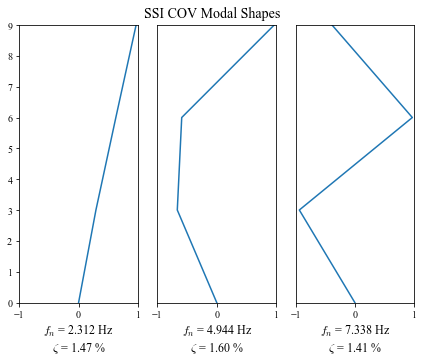

In [110]:
SSI.plot_1dshapes(FNCR,ZTCR,VVCR,'SSI COV',x,ref,fix=[0])

### 3.3.2. SSI DATA <a name="3.3.2"></a>

O método SSI DATA evita o cálculo das funções de covariância das saídas. Ele é substituído pela projeção das linhas das saídas futuras nas linhas das saídas passadas, a qual é calculada a partir da fatoração QR da matriz bloco Hankel com séries temporais das saídas $(18)$. De fato, o conceito de covariâncias e projeções estão intimamente ligados. Ambos visam cancelar o ruído. A ideia da projeção é reter toda a informação passada útil para prever o futuro. O método emprega a decomposição em valores singulares da matriz com as projeções para obter a matriz de observabilidade e a sequência de estado no filtro Kalman. As matrizes do sistema são obtidas a partir da sequência de estado do filtro Kalman (VAN OVERSCHEE; DE MOOR, 1996).

As mesmas observações feitas no método SSI COV sobre a determinação da ordem do modelo em espaço de estado $n_2$ se aplicam ao SSI DATA. A função `SSI_DATA_iterator` itera a função `SSI_DATA` para modelos de ordens crescentes. Desenha-se um diagrama de estabilização e os modos verdadeiros são identificados a partir dos polos estáveis. A decomposição QR, as projeções e a sua decomposição em valores singulares são calculadas uma única vez, devendo-se respeitar a inequação $ri≥n_{2,max}$ sendo $n_{2,max}$ a ordem máxima do modelo em espaço de estado. Modelos de ordens inferiores $n_2<n_{2,max}$ são facilmente obtidos simplesmente selecionando-se menos valores singulares.

Considerando um modelo de ordem mínima igual a 2, máxima igual a 24 e com incrementos padrão de 2 em 2.

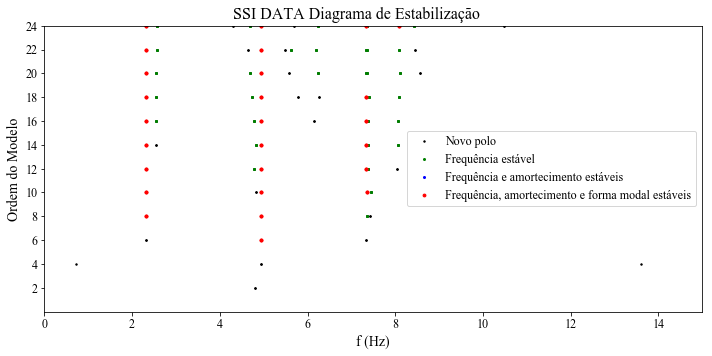

In [111]:
FND, ZTD, VVD = SSI.SSI_DATA_iterator(yk,i,2,24,2)
stbD = SSI.stabilization_diagram(FND,ZTD,VVD,'SSI DATA', tol=tol)

Em seguida, agrupam-se os polos estáveis e plotam-se as propriedades dinâmicas identificadas.

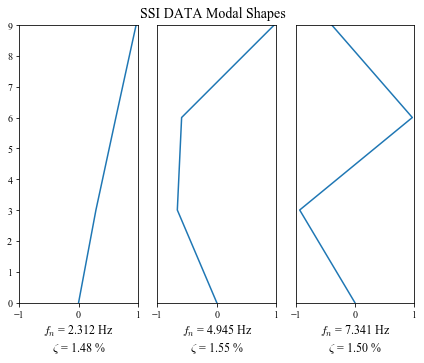

In [112]:
FNDR, ZTDR,VVDR = SSI.stable_modes(FND, ZTD, VVD, stbD, tol=0.01, spo=8)
SSI.plot_1dshapes(FNDR,ZTDR,VVDR,'SSI DATA',x,ref,fix=[0])

#### 3.3.3 Algoritmo mais eficiente para determinação das matrizes do sistema <a name="3.3.3"></a>

As funções `SSI_COV_iterator` e `SSI_DATA_iterator` empregam o algoritmo SSI tradicional, o qual realiza a identificação das matrizes a partir da matriz de observabilidade para modelos de vários número de estados. Três algortimos mais eficientes foram propostos por Döhler e Mevel (2012). Ao invés de resolver o problema para todas as ordens especificadas, os autores mostram que o problema de mínimos quadrados pode ser resolvido apenas uma vez para o modelo de mais alta ordem $n_{2,max}$ e as matrizes do sistema para modelos de ordens inferiores podem ser determinadas de forma mais eficiente.

A função `Fast_SSI` implementa o Algoritmo 2 (DÖHLER; MEVEL, 2012) para ambos os métodos SSI. Ela reduz significativamente o custo computacional para modelos de ordem elevada.

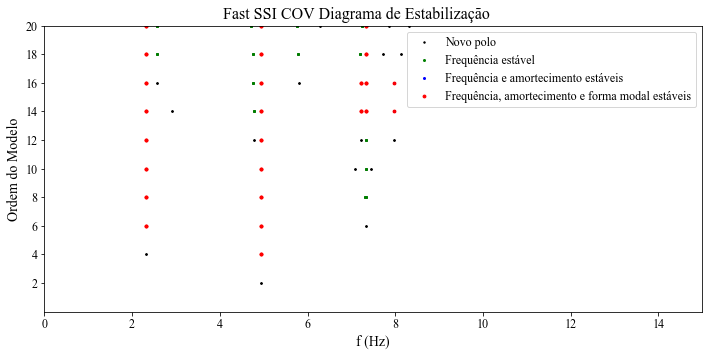

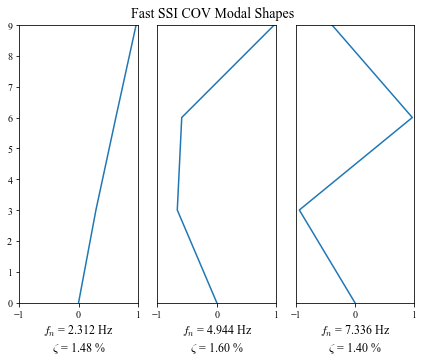

In [113]:
FNO, ZTO, VVO = SSI.Fast_SSI(yk,i,2,20,2,based='COV')
stbO = SSI.stabilization_diagram(FNO,ZTO,VVO,'Fast SSI COV', tol=tol)
FNFC, ZTFC,VVFC = SSI.stable_modes(FNO, ZTO, VVO, stbO, tol=0.01, spo=8)
SSI.plot_1dshapes(FNFC,ZTFC,VVFC,'Fast SSI COV',x,ref,fix=[0])

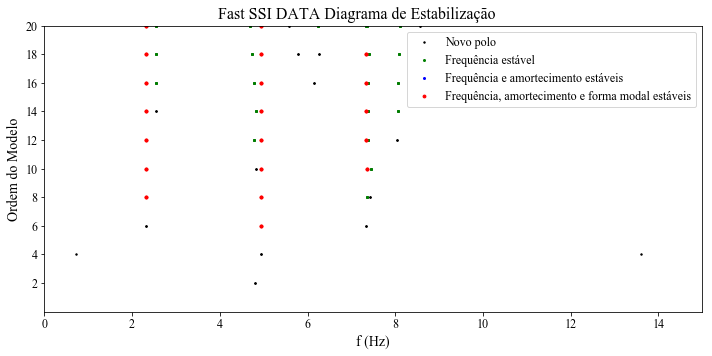

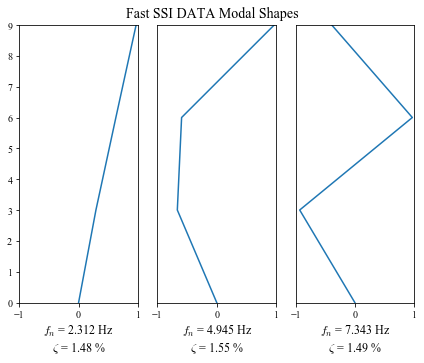

In [114]:
FNA, ZTA, VVA = SSI.Fast_SSI(yk,i,2,20,2,based='DATA')
stbA = SSI.stabilization_diagram(FNA,ZTA,VVA,'Fast SSI DATA', tol=tol)
FNFD, ZTFD,VVFD = SSI.stable_modes(FNA, ZTA, VVA, stbA, tol=0.01, spo=8)
SSI.plot_1dshapes(FNFD,ZTFD,VVFD,'Fast SSI DATA',x,ref,fix=[0])

### 3.4 Método das Variáveis Instrumentais (IV) <a name="3.4"></a>

O IV emprega a representação autorregressiva com média móvel (ARMA) e identifica os coeficientes da parte AR apenas, evitando a não-linearidade causada pela parte MA. Pode-se mostrar que para a determinação das características dinâmicas da estrutura, apenas os coeficientes da parte AR são necessários. A ideia é ajustar os coeficientes para os dados das medições, resolvendo um sistema de equações sobredeterminado por mínimos quadrados (PEETERS, 2000).

O método programado emprega a formulação com os sensores de referência proposta por Peeters (2000). Ela baseia-se no modelo autorregressivo com média móvel reverso no tempo:

$$\vec y_k^{ref} + \alpha_1^b \vec y_{k+1}^{ref} + \cdots + \alpha_p^b \vec y_{k+p}^{ref} = 
  \vec e_k^b     + \gamma_1^b \vec e_{k+1}^b     + \cdots + \gamma_p^b \vec e_{k+p}^b \tag{23}$$

Sendo $\vec y_k^{ref} \in \mathrm{\mathbb{R}}^{r}$ o vetor das saídas de referência e $\vec e_k^b \in \mathrm{\mathbb{R}}^{r}$ um vetor ruído branco. Os termos ao lado esquerdo da igualdade são a parte autorregressiva (AR) e os termos ao lado direito são a parte com média móvel (MA). As matrizes $\alpha_1^b \in \mathrm{\mathbb{R}}^{r\times r} $ contém os parâmetros da parte AR e as matrizes $\gamma_i^b \in \mathrm{\mathbb{R}}^{r\times r}$ contém os parâmetros da parte MA. 

A relação entra a ordem $p$ do modelo ARMA e seu modelo equivalente no espaço de estado é $p \times r = n_2$.

Os coeficientes da parte AR reversa são determinados resolvendo um sistema de equações por mínimos quadrados com partes da matriz Toeplitz. Estes coeficientes são agrupados em uma matriz chamada de matriz de estado na forma companheira $ \mathbf{A}_{comp}^{b,p}$. As matrizes com os autovalores e autovetores da matriz companheira são calculadas, $\mathbf{\Lambda}_d$ e $\Psi_{comp}$, respectivamente. A partir dos autovalores $\mu_i$ calculam-se as frequências naturais e razões de amortecimento. 

As formas modais são determinadas em um segundo passo. A matriz $\mathbf{G}_m^{ref}$ é obtida a partir das primeira $r$ linhas da matriz com os autovetores de $ \mathbf{A}_{comp}^{b,p}$:

$$\mathbf{G}_m^{ref} = \left( \Psi_{comp} [r,:] \right )^T \tag{24}$$

A matriz $\mathbf{\Gamma}_{p,m}^{ref}$ é calculada:

$$\mathbf{\Gamma}_{p,m} = \begin{bmatrix}  
\mathbf{\Lambda}_d^{p-1}\mathbf{G}_m^{ref} & \mathbf{\Lambda}_d^{p-2}\mathbf{G}_m^{ref} & \cdots & 
\mathbf{\Lambda}_d      \mathbf{G}_m^{ref} &                         \mathbf{G}_m^{ref}   \end{bmatrix} \tag{25}$$

E finalmente as formas modais:

$$\mathbf{V} = \begin{bmatrix} \mathbf{R}_p^{ref} & \mathbf{R}_{p-1}^{ref} & \cdots & \mathbf{R}_1^{ref} \end{bmatrix} 
\left ( \mathbf{\Gamma}_{p,m} \right )^{-1} \tag{26}$$

Semelhante aos métodos anteriores, o processo de identificação é realizado para modelos com ordens crescentes e a identificação dos modos de vibração verdadeiros é feita com auxílio do diagrama de estabilização. A função `IV_iterator` faz esse processo. Nela, especifica-se uma ordem máxima $p_{max}$ do modelo ARMA, a partir da qual a ordem máxima do modelo em espaço de estado $n_{2,max}$ é obtida fazendo-se $n_{2,max}=p_{max}\times r$ e a matriz Toeplitz é calculada uma única vez. Modelos de ordens inferiores $p<p_{max}$ são facilmente obtidos simplesmente selecionando-se menos elementos da matriz Toeplitz. 

Para um modelo de ordem ARMA mínima igual a 1, máxima igual a 18 com incrementes de 1 em 1:

C:\Users\mathe\Desktop\Tese\Python\Release rev\Português\CESSIPy.py:556: RuntimeWarning: invalid value encountered in log
  λ  =  np.log(Λd)*T.fs
C:\Users\mathe\Desktop\Tese\Python\Release rev\Português\CESSIPy.py:690: RuntimeWarning: invalid value encountered in less
  b1 = (np.abs(res/FN[ii,:no]) < tol[0,0]) & b1
C:\Users\mathe\Desktop\Tese\Python\Release rev\Português\CESSIPy.py:697: RuntimeWarning: invalid value encountered in less
  b2 = (np.abs(res/ZT[ii,:no]) < tol[1,0]) & b2 & b1


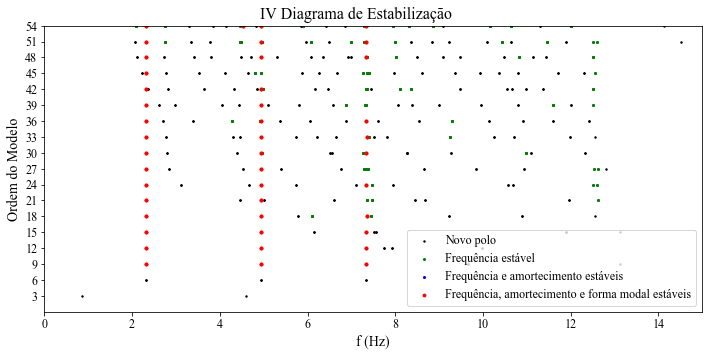

In [115]:
FNI, ZTI, VVI = SSI.IV_iterator(yk,i,1,18,1)
stbI = SSI.stabilization_diagram(FNI, ZTI, VVI,'IV', tol=tol)

As propriedades dinâmicas identificadas:

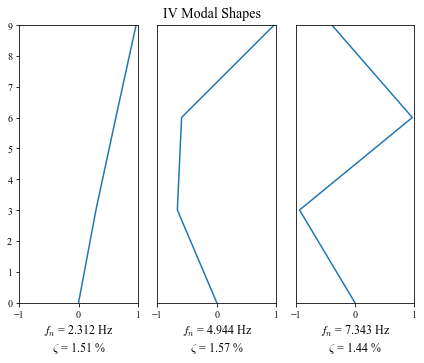

In [116]:
FNIR, ZTIR,VVIR = SSI.stable_modes(FNI, ZTI, VVI, stbI, tol=0.01, spo=8)
SSI.plot_1dshapes(FNIR,ZTIR,VVIR,'IV',x,ref,fix=[0])

## 4. Outras rotinas <a name="4"></a>

Nesta seção apresentam-se as rotinas para geração de gráficos das propriedades dinâmicas de edifícios, cálculo do Critério de Concordância Modal e geração de gráfico dos valores singulares.

### 4.1. Gráfico das propriedades dinâmicas de edifícios <a name="4.1"></a>

Elaborou-se a rotina `plot_3das1d` para representação das propriedades dinâmicas de edifícios. Cada forma modal deve estar nas colunas da matriz informada, sendo as linhas com índices `0::3` para as componentes na direção $x$, as linhas com índices `1::3` para componentes na direção $y$ e `2::3` para as componentes em $\theta_z$.

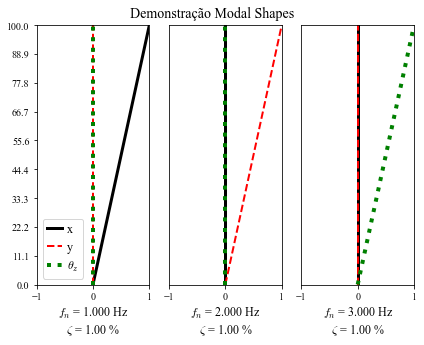

In [117]:
fnt = np.array((1,2,3))     # frequências naturais
ztt = 0.01*np.ones(3)       # razões de amortecimento
qt  = np.array(([1,0,0],    # componentes x das formas modais
                [0,1,0],    # componentes y das formas modais
                [0,0,1]))   # componentes θz das formas modais
xt  = np.array((100,))      # altura do sensor

SSI.plot_3das1d(fnt,ztt,qt,xt,title='Demonstração')

Na formulação com sensores de referência, as componentes modais desses sensores são posicionadas nas primeiras linhas das formas modais identificadas. Como consequência, pode ser necessário rearranjar as formas modais. Isso é feito especificando uma tupla `ref`. Se os sensores de referência estiverem em `xt[1]`, especifica-se `ref=(1)`.

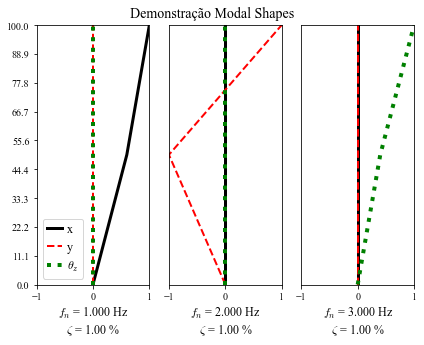

In [118]:
fnt = np.array((1,2,3))
ztt = 0.01*np.ones(3)
qt  = np.array(([  1,0,0],[0, 1,0],[0,0,  1],  # componentes modais para xt[0]
                [0.6,0,0],[0,-1,0],[0,0,0.4])) # componentes modais para xt[1]
xt  = np.array((100,50))

SSI.plot_3das1d(fnt,ztt,qt,xt,title='Demonstração',ref=(0))

### 4.2. Critério de Concordância Modal (MAC) <a name="4.2"></a>

O Critério de Concordância Modal (*Modal Assurence Criterion* – MAC), proposto por Allemang e Brown (1982), é uma medida de correlação entre duas formas modais. O seu valor varia entre 0 e 1, sendo igual zero para modos não correlacionados e um para modos perfeitamente correlacionados. Sejam as formas modais complexas $\vec \psi_i$ e $\vec \psi_j$, o MAC é calculado: 

$$MAC(i,j)= \frac {\left | \vec \psi_i^T \vec \psi_j^*  \right |^2} 
              {\left ( \vec \psi_i^T \vec \psi_i^*  \right )\left ( \vec \psi_j^T \vec \psi_j^*  \right )}	\tag{27}$$

Na qual $(\cdot)^*$ denota complexo conjugado. Os vetores $\vec \psi_i$ e $\vec \psi_j$ podem ser substituídos por matrizes cujas colunas são as formas modais. Neste caso, o emprego da expressão $(27)$ resultará em uma matriz. 

Uma forma útil de visualizar os valores do MAC é de forma gráfica, permitindo que mais dados sejam apresentados e compreendidos.

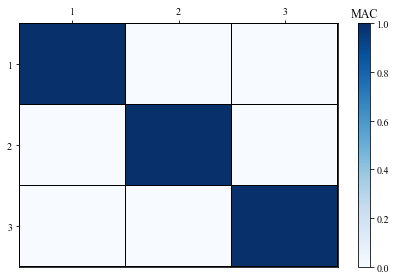

In [119]:
MAC = SSI.MAC(qt,qt,plot=True)

### 4.3. Gráfico dos valores singulares <a name="4.3"></a>

A contagem dos valores singulares não nulos fornece uma estimativa do número de modos físicos presentes nos sinais. Quando a ordem verdadeira do modelo for excedida, os valores singulares irão teoricamente para zero. Na figura abaixo é possível identificar seis valores singulares não nulos, indicando que se trata de um modelo com ordem no espaço de estado $n_2=6$. Para dados experimentais, os valores singulares não são exatamente zero, mas muito pequenos. Assim, a taxa de variação dos valores singulares em função da ordem do modelo é utilizada como indicador. Uma abordagem é normalizar os valores singulares pelo primeiro (e maior), conforme gráfico $(b)$. O posto é escolhido quando a curva se torna assintótica. Outra abordagem é dividir cada valor singular pelo imediatamente anterior $(c)$ formando uma curva com valores próximos da unidade se os valores não mudarem de magnitude. A ordem do modelo é identificada quando a relação cai subitamente.

A função `plot_singular_values` plota os gráficos dos valores singulares.

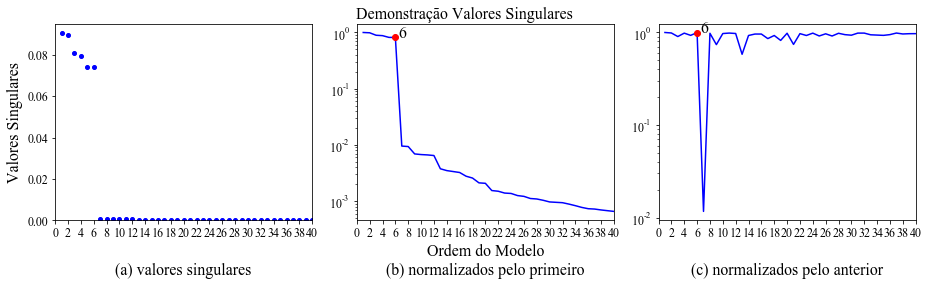

In [120]:
T = SSI.Toeplitz(yk, i)
T.method = 'Demonstração'
SSI.plot_singular_values(T,figsize=(13,4))

## Referências

ALLEMANG, R. J.; BROWN, D. L. A Correlation Coefficient for Modal Vector Analysis. In: International Modal Analysis Conference, 1st, Orlando. **Proceedings…** Orlando: IMAC, p. 110-116, Nov. 1982.

BENDAT, J. S.; PIERSOL, A. G. **Random Data**: analysis and measurement procedures. 4th ed. New York: Wiley, 2010.

BRINCKER, R.; ZHANG, L.; ANDERSEN, P. Modal Identification from Ambient Responses using Frequency Domain Decomposition. In: International Modal Analysis Conference, 18th, 2000, San Antonio. **Proceedings…** San Antonio: IMAC, p. 625-630, Feb. 2000.

BRINCKER, R.; VENTURA, C. E.; ANDERSEN, P. Damping Estimation by Frequency Domain Decomposition. In: International Modal Analysis Conference, 19th, 2001, Orlando. **Proceedings…** Orlando: IMAC, p. 698-703, Feb. 2001.

CLOUGH, R. W.; PENZIEN, J. **Dynamics of Structures**. 3rd ed. Berkeley: Computers & Structures, 2003.

DÖHLER, M.; MEVEL, L. Fast Multi-Order Computation of System Matrices in Subspace-Based System Identification. **Control Engineering Practice**, v. 20, n. 9, p. 882-894, Mar. 2012.

EWINS, D. J. **Modal Testing**: theory, practice and application. 2nd ed. Baldock: Research Studies, 2000.

FELBER, A. J. **Development of a Hybrid Bridge Evaluation System**. 1993. 277 f. Thesis (Ph. D.) – Department of Civil Engineering, University of British Columbia, British Columbia, 1993.

HU, W.; CUNHA, A.; CAETANO, E.; MAGALHÃES, F.; MOUTINHO, C. LabVIEW toolkits for output-only modal identification and long-term dynamic structural monitoring. **Structure and Infrastructure Engineering**, v. 6, n. 5, p. 557-574, Oct. 2010.

OVERSCHEE, P. V.; MOOR, B. D. **Subspace identification for linear systems**: theory – implementation – applications. Leuven: Kluwer, 1996. 

PEETERS, B. **System Identification and Damage Detection in Civil Engineering**. 2000. 238 f. Proefschrift (Doctoraat in de toegepaste wetenschappen) – Departement Burgerlijke Bouwkunde, Katholieke Universiteit Leuven, Leuven, 2000.

RODRIGUES, J. **Identificação Modal Estocástica**: métodos de análise e aplicações em estruturas de engenharia civil. 2004. 484 f. Dissertação (Doutorado em Engenharia Civil) – Faculdade de Engenharia, Universidade do Porto, Porto, 2004.